In [78]:
import numpy as np
import shutil
import os
import random
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import Callback
from keras import backend as K
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

## Train - val - test split

In [52]:
root_dir = '../data/data_151'
target_dir = '../data'

In [55]:
pokemon_list = ['Bulbasaur', 'Venusaur', 'Charmander', 'Charizard', 'Squirtle',
           'Blastoise', 'Pikachu', 'Eevee', 'Moltres', 'Zapdos', 
           'Articuno', 'Mewtwo', 'Mew', 'Lapras', 'Dragonite',
           'Alakazam', 'Gengar', 'Snorlax', 'Gyarados', 'Arcanine',
           'Jolteon', 'Vaporeon', 'Flareon', 'Scyther', 'Dugtrio',
           'Pidgeot', 'Starmie', 'Magneton', 'Aerodactyl', 'Ditto']

In [58]:
for pokemon in pokemon_list:
    files = os.listdir(f'{root_dir}/{pokemon}')
    random.seed(1)
    random.shuffle(files)
    
    train, validation, test = files[:90], files[90:105], files[105:]
    for folder, dataset in zip(['train', 'validation', 'test'],
                                 [train, validation, test]):
        for file in dataset:
            if not os.path.exists(f'{target_dir}/{folder}/{pokemon}'):
                os.makedirs(f'{target_dir}/{folder}/{pokemon}')
            shutil.copyfile(f'{root_dir}/{pokemon}/{file}',
                            f'{target_dir}/{folder}/{pokemon}/{file}')

## Image Preprocessing

In [2]:
img_width, img_height = 150, 150

In [60]:
train_data_dir = f'{target_dir}/train'
validation_data_dir = f'{target_dir}/validation'
nb_train_samples = 90 * len(pokemon_list)
nb_validation_samples = 15 * len(pokemon_list)

In [62]:
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

In [63]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 2700 images belonging to 30 classes.
Found 450 images belonging to 30 classes.


## Model

In [86]:
n_conv_layers = 4
n_kernels = [64] * n_conv_layers
model = Sequential()
model.add(BatchNormalization(input_shape=(img_width, img_height, 3)))

for i in range(n_conv_layers):
    model.add(Conv2D(n_kernels[i], (3, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

In [87]:
model.add(Flatten())
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(len(pokemon_list)))
model.add(Activation('softmax'))

In [88]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [89]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_8 (Batch (None, 150, 150, 3)       12        
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 148, 148, 64)      1792      
_________________________________________________________________
batch_normalization_9 (Batch (None, 148, 148, 64)      256       
_________________________________________________________________
activation_20 (Activation)   (None, 148, 148, 64)      0         
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 72, 72, 64)        36928     
_________________________________________________________________
batch_normalization_10 (Batc (None, 72, 72, 64)        256       
__________

## MobileNet

In [93]:
from keras.applications import ResNet50
from keras.applications import MobileNet

In [95]:
model = MobileNet(input_shape=(img_width, img_height, 3), weights=None, classes=(len(pokemon_list)))

In [100]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [101]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 75, 75, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 75, 75, 32)        128       
_________________________________________________________________
conv1_relu (Activation)      (None, 75, 75, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 75, 75, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 75, 75, 32)        128       
_________________________________________________________________
conv_dw_1_relu (Activation)  (None, 75, 75, 32)        0         
__________

## Execution

In [102]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

In [103]:
epochs = 10
batch_size = 128
history = LossHistory()
model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    callbacks=[history])

Epoch 1/10
21/21 [==============================] - 140s 7s/step - loss: 3.9791 - acc: 0.0476 - val_loss: 3.4345 - val_acc: 0.0208
Epoch 2/10
21/21 [==============================] - 122s 6s/step - loss: 3.7291 - acc: 0.0238 - val_loss: 3.4616 - val_acc: 0.0208
Epoch 3/10
21/21 [==============================] - 105s 5s/step - loss: 3.4879 - acc: 0.0774 - val_loss: 3.4951 - val_acc: 0.0000e+00
Epoch 4/10
21/21 [==============================] - 131s 6s/step - loss: 3.4983 - acc: 0.0685 - val_loss: 3.5481 - val_acc: 0.0208
Epoch 5/10
21/21 [==============================] - 107s 5s/step - loss: 3.4077 - acc: 0.0536 - val_loss: 3.5633 - val_acc: 0.0208
Epoch 6/10
21/21 [==============================] - 108s 5s/step - loss: 3.3120 - acc: 0.0625 - val_loss: 3.6977 - val_acc: 0.0208
Epoch 7/10
21/21 [==============================] - 113s 5s/step - loss: 3.3532 - acc: 0.0833 - val_loss: 3.7405 - val_acc: 0.0000e+00
Epoch 8/10
21/21 [==============================] - 106s 5s/step - loss: 3.

In [106]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

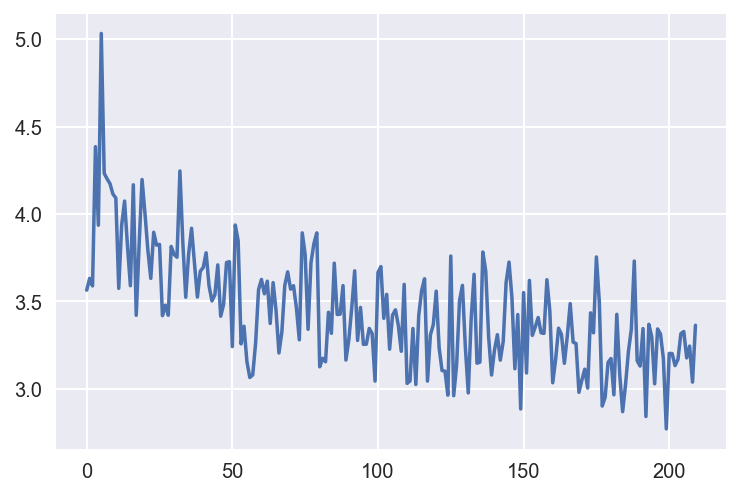

In [107]:
plt.plot(history.losses)

## Next Steps

- Transfer Learning
- More training less test data 100-20
- Less classes?
- Check data augmentation
- Weight initialization